# Criticality
This notebook contains experiments in determining how far away a network is from criticality. Also, what happens if you homeostatically regulate firing rates?

In [1]:
%matplotlib nbagg
import numpy as np
from scipy import optimize, stats, signal

from braingeneers.drylab import Organoid
from braingeneers.analysis import temporal_binning, find_avalanches, vuong

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [2]:
# This is specific to my MPL configuration...
plt.style.use('arxiv')

## Load Spikes from Disk

In [ ]:
#!scp plaza:spikes.npz ./spikes1.npz
npz = np.load('spikes1.npz')
spike_times, spike_idces = npz['times'], npz['idces']

## Simulate Spikes In Here

In [112]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))
# mV : peak cutoff of action potentials
Vp = 30

# tau : ms time constant of synaptic current
tau = np.hstack((5*l[:Ne], 20*l[Ne:]))


In [113]:
# Sij : fC total postsynaptic charge injected into
#       neuron i when neuron j fires. Song (2005)
#       provide an empirical distribution for EPSPs.
mu, sigma = -0.702, 0.9355  
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
# Then convert the EPSPs to injected synaptic charge.
S *= np.median(C / tau) * 10

# Also choose random pairs of cells to be connected 
# to each other, at a rate of about 10%.
S *= np.random.rand(N,N) <= 0.1

# XY : um planar positions of the cells,
# dij : um distances between cells
XY = np.random.rand(2,N) * 75

S[:,Ne:] *= -10
S[Ne:,Ne:] = 0

In [114]:
# Sample rate (kHz) and timestep (ms)
fs = dt = 1
tmax = 100000

# Create the actual Organoid.
org = Organoid(XY=XY, S=S/2, tau=tau, Vp=Vp,
               a=a, b=b, c=c, d=d, k=k, C=C, Vr=Vr, Vt=Vt)

# Initialize and run the loop.
spike_times, spike_idces = [], []
for t in tqdm(range(tmax)):

    Iin = 150*np.random.randn(N)
    org.step(dt, Iin)

    for i in np.arange(N)[org.fired]:
        spike_times.append(t)
        spike_idces.append(i)

spike_times = np.array(spike_times)
spike_idces = np.array(spike_idces, dtype=np.int32)

<IPython.core.display.Javascript object>


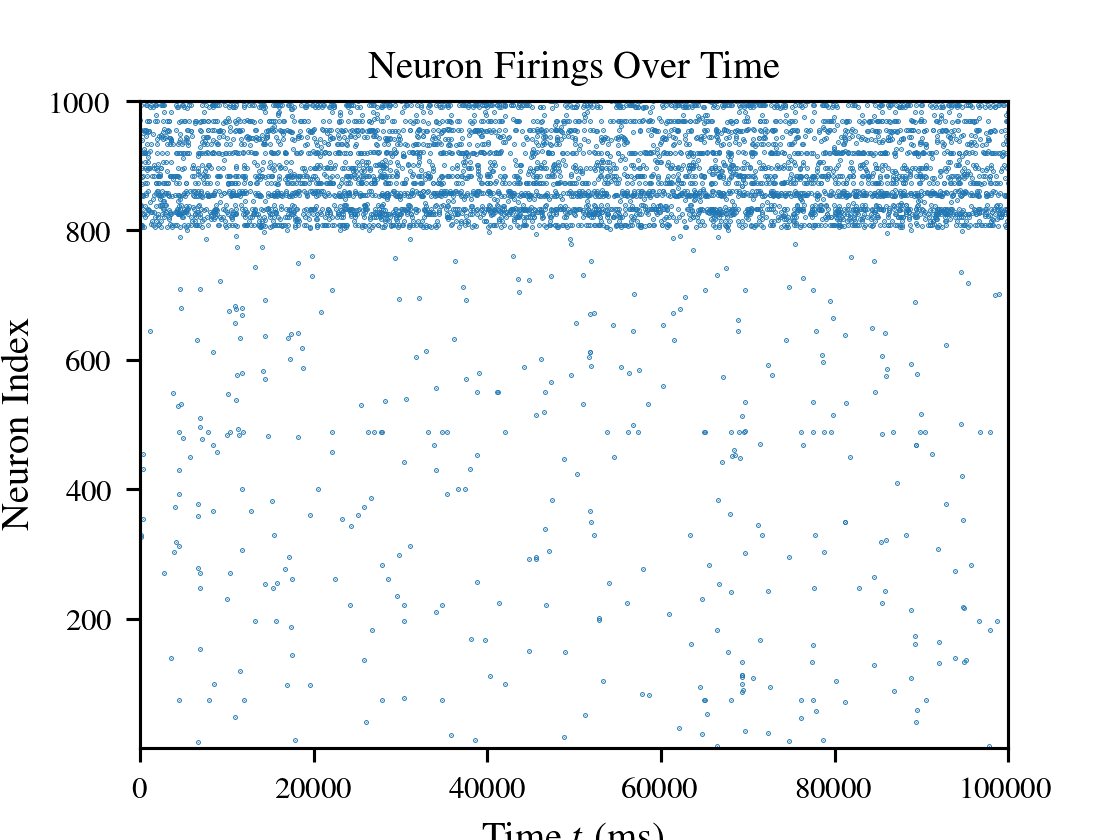

(1, 1000)

In [133]:
plt.figure()
plt.plot(spike_times, spike_idces + 1, '.', markersize=0.5)
plt.title('Neuron Firings Over Time')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0,max(spike_times)])
plt.ylim([1,N])

## Count the Counts, Find the Threshold

In [134]:
counts = temporal_binning(spike_times)
thresh = stats.mstats.mquantiles(counts, [0.35])[0]

In [149]:
sizes, durations = np.array(find_avalanches(counts, thresh)).T
durations = durations * 40e-3
print(f'There were {len(sizes)} avalanches!')
print(f'  Size: {sizes.min()} to {sizes.max()} spikes.')
print(f'  Duration: {int(1000*durations.min())}ms to {int(1000*durations.max())}ms.')

There were 549 avalanches!
  Size: 2 to 42 spikes.
  Duration: 40ms to 560ms.


## Scale-Free Avalanche Shapes?
Scale-free dynamics should have the property that avalanches of different sizes look like scaled copies of each other. The simulated example does not exhibit this property at all: there is no relationship between avalanche shapes, even if we restrict ourselves to avalanches above a certain size.

<IPython.core.display.Javascript object>


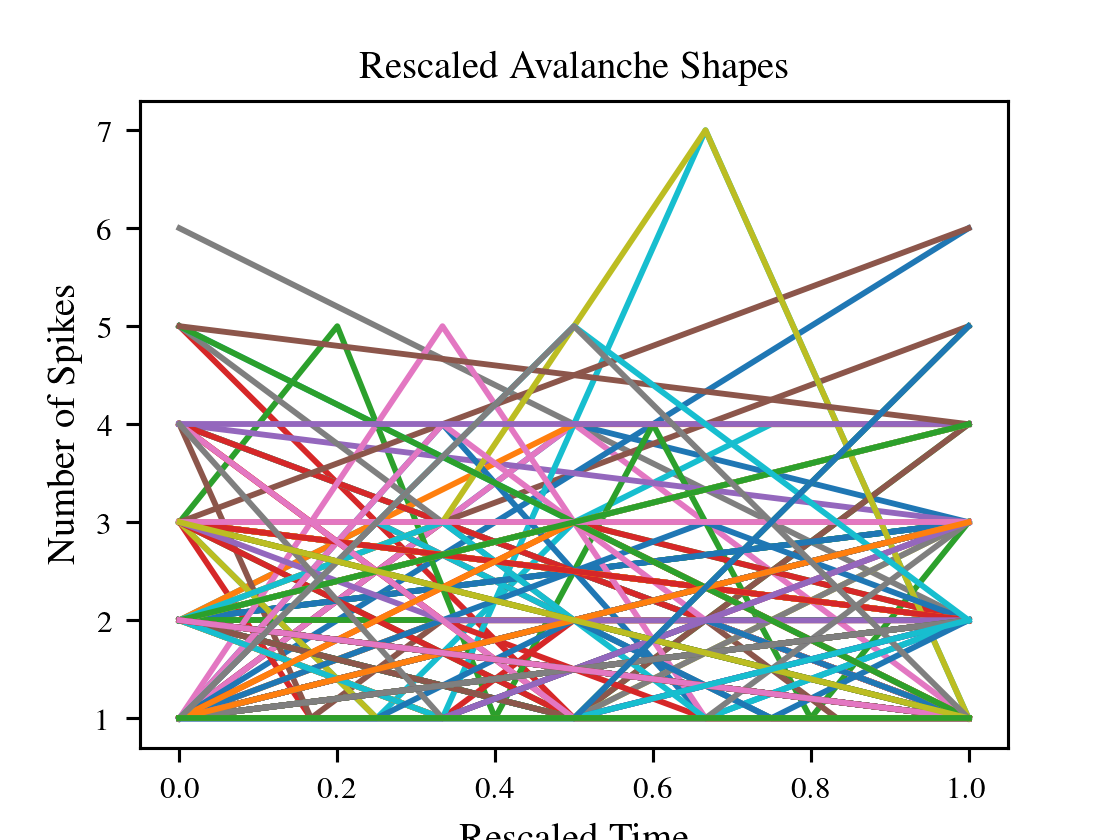

In [150]:
ax = plt.figure().gca()      
ax.set_title('Rescaled Avalanche Shapes')
ax.set_xlabel('Rescaled Time')
ax.set_ylabel('Number of Spikes')

av = []
for count in counts:
    if count > thresh:
        av.append(count - thresh)
    else:
        if len(av) > 1:
            av = np.array(av)
            ax.plot(np.linspace(0,1, len(av)), av)
        av = []
  

## Fitting Distributions
Try fitting both a power-law and a lognormal distribution to the observed distribution of avalanche sizes and durations (via the maximum likelihood method), then compare the predictions of those two fits using the Vuong test. 

The Vuong statistic is a measure (based on a likelihood ratio) of how sure we can be based on a certain sample that data fits model A better than model B. If the two models fit equally well, the statistic follows the standard normal distribution. Here, we estimate the Vuong statistic by doing little Vuong tests on many independent samples of the observed avalanche distribution, as well as on samples of the two fitted distributions. It is obvious, at least for now, that the lognormal model fits the data very well and the power-law model does not. 

In [151]:
size_kde = stats.gaussian_kde(sizes)
size_kde.args = sizes
size_pl = stats.powerlaw(*stats.powerlaw.fit(sizes, floc=0))
size_ln = stats.lognorm(*stats.lognorm.fit(sizes, floc=0))

duration_kde = stats.gaussian_kde(durations)
duration_kde.args = durations 
duration_pl = stats.powerlaw(*stats.powerlaw.fit(durations, floc=0))
duration_ln = stats.lognorm(*stats.lognorm.fit(durations, floc=0))

In [164]:
n, k = 1000, 30
vuong_real = np.array([vuong(np.random.choice(sizes, k), 
                             size_ln, size_pl)[0]
                       for _ in range(n)])
vuong_ln = np.array([vuong(size_ln.rvs(k), 
                           size_ln, size_pl)[0]
                     for _ in range(n)])
vuong_pl = np.array([vuong(size_pl.rvs(k), 
                           size_ln, size_pl)[0]
                     for _ in range(n)])

<IPython.core.display.Javascript object>


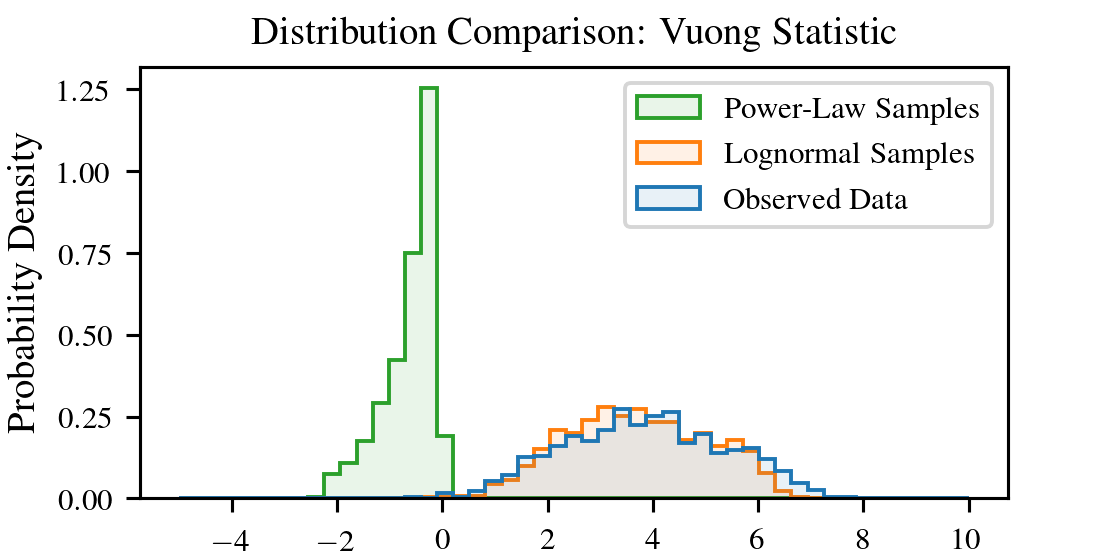

In [167]:
ax = plt.figure(figsize=(4,2)).gca()
ax.set_title('Distribution Comparison: Vuong Statistic')
ax.set_xlabel('Vuong Statistic')
ax.set_ylabel('Probability Density')
buckets = np.linspace(-5, 10)
_, _, patches = \
    ax.hist((vuong_real, vuong_ln, vuong_pl), 
            buckets, density=True, histtype='step',
            label=('Observed Data', 
                   'Lognormal Samples', 
                   'Power-Law Samples'))
# Ugly code to make pretty graphs.
for poly in patches:
    r, g, b, _ = poly[0].get_edgecolor()
    poly[0].set_facecolor((r,g,b,0.1))
    poly[0].set_fill(True)
ax.legend()

## Direct Distribution Comparison
Here, we plot the difference the kernel density estimate of the empirical distribution, and the two maximum-likelihood estimated probability distributions. The results are pretty impossible to argue in this case as well. An exponential distribution also fits pretty well, but lognormal is a little bit better.

<IPython.core.display.Javascript object>


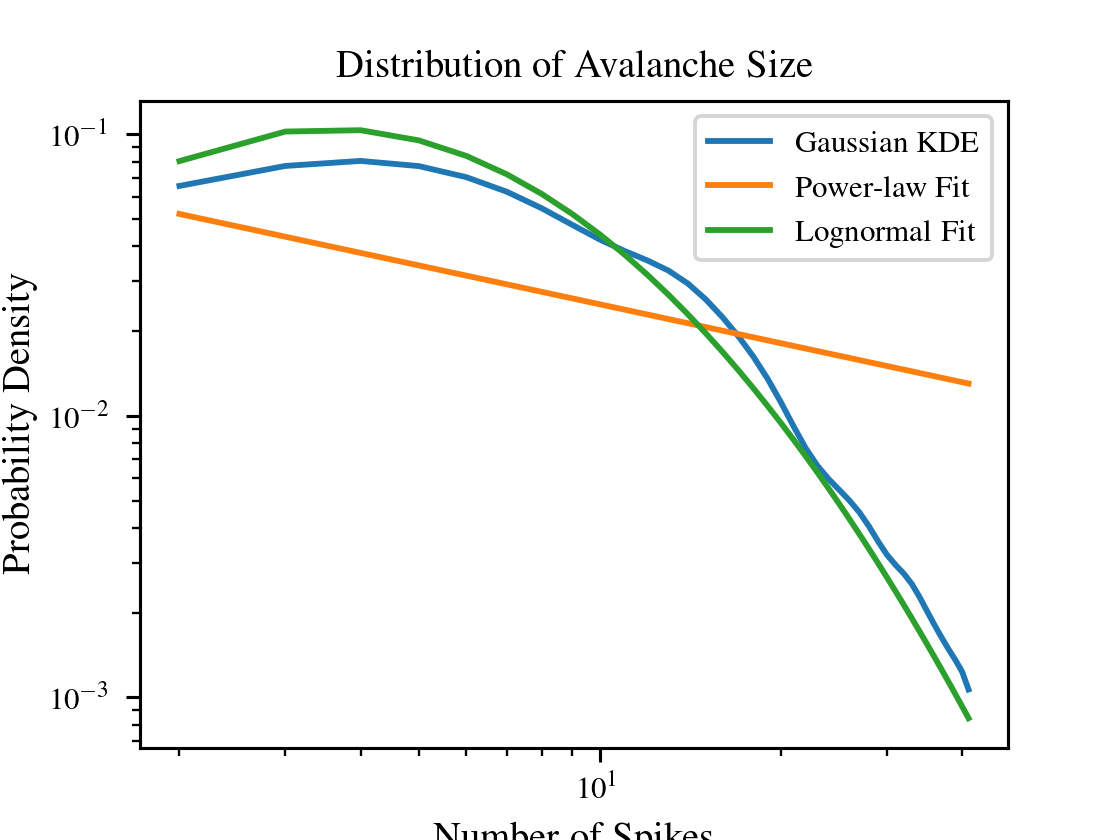

In [174]:
ax = plt.figure().gca()
ax.set_title('Distribution of Avalanche Size')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Number of Spikes')
srange = np.arange(sizes.min(), sizes.max())
ax.loglog(srange, size_kde.pdf(srange), label='Gaussian KDE')
ax.plot(srange, size_pl.pdf(srange), label='Power-law Fit')
ax.plot(srange, size_ln.pdf(srange), label='Lognormal Fit')
ax.legend()

<IPython.core.display.Javascript object>


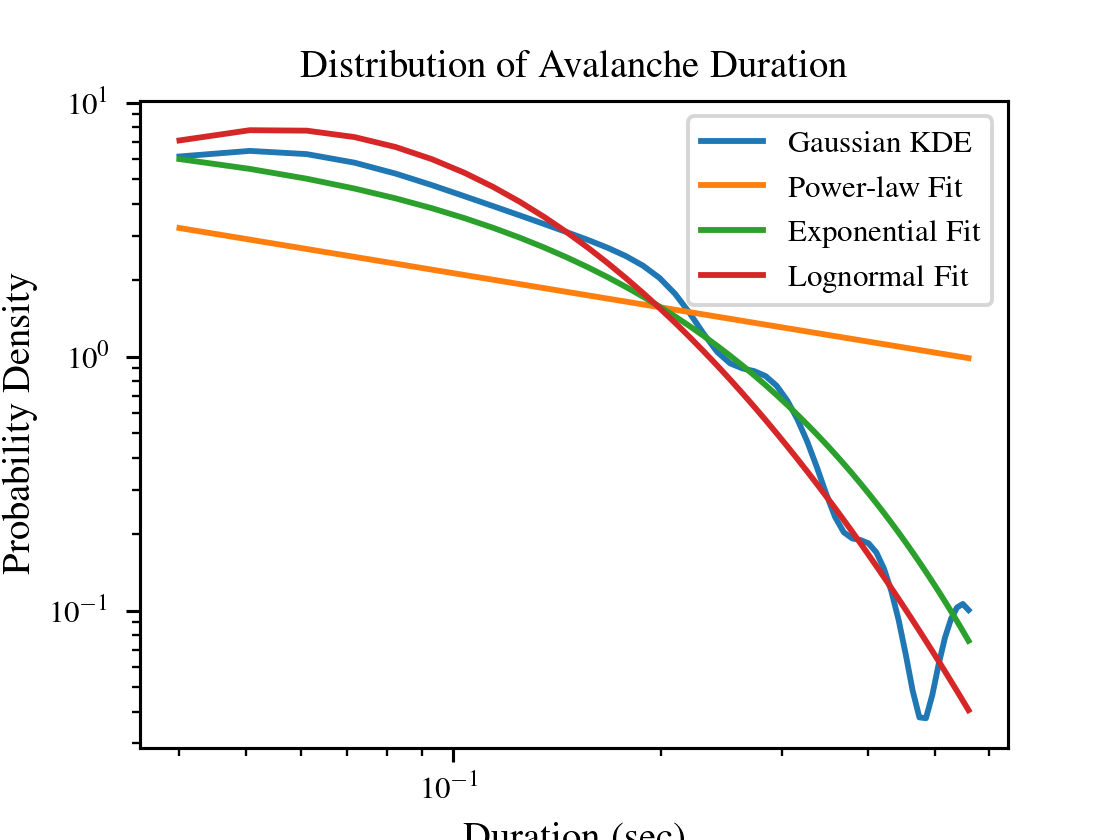

In [155]:
ax = plt.figure().gca()
ax.set_title('Distribution of Avalanche Duration')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Duration (sec)')
drange = np.linspace(durations.min(), durations.max())
ax.loglog(drange, duration_kde.pdf(drange), label='Gaussian KDE')
ax.plot(drange, duration_pl.pdf(drange), label='Power-law Fit')
ax.plot(drange, duration_ln.pdf(drange), label='Lognormal Fit')
ax.legend()

## DCC Calculation
If the data _did_ actually seem to follow a power law, this code would calculate the DCC and determine that we are actually at criticality. However, since the data aren't even scale-free in the first place, any calculated DCC value is garbage.

Also note that the relationship between duration and spike count is linear ($m=1$), which means that the average number of spikes per time has no relationship to avalanches. This is another proof that the model is nowhere near critical. The typical human value 

In [180]:
from scipy import optimize
def powerlaw(x, a,b):
    return a*x**b

(scale,m),_ = optimize.curve_fit(powerlaw, durations, sizes)
print(f'Fitted value of m: {m}')

Fitted value of m: 1.002162081161398


In [176]:
alpha, tau = 1/duration_pl.args[0], 1/size_pl.args[0]
m_pred = (tau - 1) / (alpha - 1)
print(f'DCC = {abs(m_pred - m)}')

DCC = 0.04801532343787063


<IPython.core.display.Javascript object>


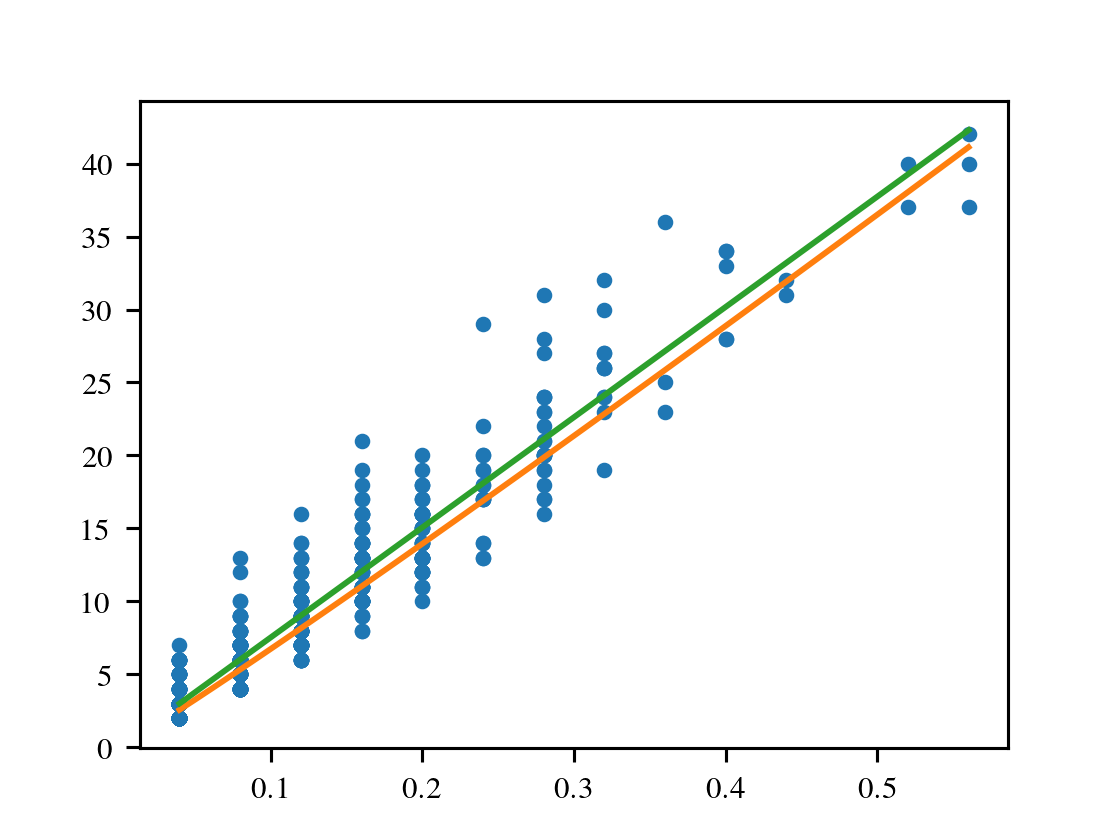

In [177]:
ax = plt.figure().gca()
ax.plot(durations, sizes, '.')
ax.plot(drange, scale*drange**m_pred)
ax.plot(drange, scale*drange**m)